In [23]:
# KNN
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import holidays
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import random
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm
from scipy.interpolate import make_interp_spline


def create_error_rate_data(initial_df, test_start_date, percent_gaps):
    df_orig = initial_df.copy()
    df_test = initial_df.copy()
    df_test_drop = initial_df.copy()
    df_test_drop = df_test_drop[df_test_drop.index >= test_start_date]

    len_deleted = int(len(df_test_drop.dropna()) * (percent_gaps / 100))
    start_index_delete_random = np.random.randint(0, len(df_test_drop.dropna()) - len_deleted)
    long_random_drop_indexes_list = list(range(start_index_delete_random, start_index_delete_random + len_deleted))

    date = df_test_drop.dropna().index[long_random_drop_indexes_list]
    drop_indexes = df_test_drop.index[df_test_drop.index.isin(date)].tolist()
    print(f'Начало вырезки - {drop_indexes[0]}\nКонец - {drop_indexes[-1]}\nДлина вырезки - {len(drop_indexes)}')
    df_for_intervals = df_orig.loc[drop_indexes]

    load_intervals = recive_quantile_internals(df_for_intervals)

    df_test['P_l_interval'] = df_test['P_l'].apply(lambda x: find_interval(x, load_intervals))
    df_orig['P_l_interval'] = df_orig['P_l'].apply(lambda x: find_interval(x, load_intervals))

    df_test['is_droped'] = False
    df_test.loc[df_test.index.isin(date), 'P_l'] = np.nan
    df_test.loc[df_test.index.isin(date), 'is_droped'] = True

    return df_orig, df_test, drop_indexes


def fill_gaps_with_knn(df, n_neighbors=3):
    # Создание копии DataFrame для изменений
    filled_df = df.copy()

    # Индексы с пропущенными значениями в колонке 'P_l'
    missing_indices = filled_df[filled_df['P_l'].isnull()].index

    # Отбор признаков
    features = filled_df.drop(columns=['P_l_interval', 'is_droped'])

    # Использование KNN для заполнения пропущенных значений
    imputer = KNNImputer(n_neighbors=n_neighbors)
    features_filled = imputer.fit_transform(features)

    # Преобразование заполненных признаков обратно в DataFrame
    filled_features = pd.DataFrame(features_filled, index=df.index, columns=features.columns)
    
    # Обновление DataFrame только для пропущенных значений в колонке 'P_l'
    filled_df.loc[missing_indices, 'P_l'] = filled_features.loc[missing_indices, 'P_l']

    return filled_df



def calculate_mape_improved(df_orig, df_predict):
    original_series = df_orig.loc[drop_indexes, 'P_l']
    predicted_series = df_predict.loc[drop_indexes, 'P_l']

    original_series = original_series.astype(float)
    predicted_series = predicted_series.astype(float)

    general_mape = np.mean(np.abs((original_series - predicted_series) / original_series)) * 100
    df_predicted_with_error = df_predict.copy()
    mape_values = []
    for index in drop_indexes:
        original_value = df_orig.loc[index, 'P_l']
        predicted_value = df_predict.loc[index, 'P_l']

        mape = np.abs((original_value - predicted_value) / original_value) * 100
        mape_values.append(mape)

    df_predicted_with_error.loc[drop_indexes, 'MAPE'] = mape_values

    mape_by_interval = {}
    for curr_interval in df_predicted_with_error['P_l_interval'].unique():
        df_curr_interval = df_predicted_with_error[df_predicted_with_error['P_l_interval'] == curr_interval]
        df_curr_interval = df_curr_interval[df_curr_interval['is_droped']==True]
        mape = np.mean(df_curr_interval['MAPE'])
        mape_by_interval[curr_interval] = mape

    mape_by_interval = sorted(mape_by_interval.items(), key=lambda x: x[0])
    mape_by_interval = [item for item in mape_by_interval if not np.isnan(item[0]) and not np.isnan(item[1])]
    mape_by_interval = sorted(mape_by_interval, key=lambda x: x[0])
    return df_predicted_with_error, general_mape, mape_by_interval


def calculate_metrics_per_interval(df_orig, df_filled, metric_name):
    df_orig = df_orig.loc[drop_indexes]  # Remove the comma here
    df_filled = df_filled.loc[drop_indexes]
    metrics_by_interval = {}
    for interval in sorted(df_filled['P_l_interval'].unique()):
        orig_values = df_orig[df_orig['P_l_interval'] == interval]['P_l']
        filled_values = df_filled[df_filled['P_l_interval'] == interval]['P_l']
        if metric_name == 'MAPE':
            metric_value = np.mean(np.abs((orig_values - filled_values) / orig_values)) * 100
        elif metric_name == 'RMSE':
            metric_value = np.sqrt(mean_squared_error(orig_values, filled_values))
        elif metric_name == 'R2':
            metric_value = r2_score(orig_values, filled_values)
        elif metric_name == 'MAE':
            metric_value = mean_absolute_error(orig_values, filled_values)
        metrics_by_interval[interval] = metric_value
    return metrics_by_interval

def calculate_and_plot_metrics(df_orig, df_filled, intervals):
    metrics = ['MAPE', 'RMSE', 'R2', 'MAE']
    results = {}

    for metric in metrics:
        results[metric] = calculate_metrics_per_interval(df_orig, df_filled, metric)

    return results


def find_interval(value, load_intervals):
    for i in range(len(load_intervals)-1):
        low_interval = load_intervals[i]
        hight_interval = load_intervals[i+1]
        if value >= low_interval and value < hight_interval:
            interval_num = int(load_intervals.index(low_interval))
            return interval_num


def create_intervals(df, column='P_l', upper_percentile=99, lower_percentile=1, num_classes=10):
    # Определяем верхнюю границу, используя заданный процентиль
    upper_limit = np.percentile(df[column], upper_percentile)
    
    # Определяем нижнюю границу, используя заданный процентиль
    lower_limit = np.percentile(df[column], lower_percentile)
    
    # Генерируем равномерные интервалы между нижним и верхним пределами
    load_intervals = np.linspace(lower_limit, upper_limit, num_classes + 1)
    load_intervals = load_intervals.tolist()
    
    return load_intervals


def recive_quantile_internals(df):
    data = df['P_l']
    q_5 = data.quantile(0.025)
    q_95 = data.quantile(0.975)
    
    trimmed_data = data[(data >= q_5) & (data <= q_95)]
    
    mu, sigma = trimmed_data.mean(), trimmed_data.std()
    
    x = np.linspace(data.min(), data.max(), 100)
    gaussian_curve = norm.pdf(x, mu, sigma)
    
    hist, bins, _ = plt.hist(data, bins=100, density=True, alpha=0.6, color='g')
    
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    
    spl = make_interp_spline(bin_centers, hist, k=2)  
    smooth_bin_centers = np.linspace(bin_centers.min(), bin_centers.max(), 100)  
    smooth_hist = spl(smooth_bin_centers)
    
    plt.plot(smooth_bin_centers, smooth_hist, color='orange', linestyle='-', linewidth=2, label='Top of Bins')
    
    plt.plot(x, gaussian_curve, 'k--', label='Gaussian Curve')
    
    plt.axvline(q_5, color='r', linestyle='--', label='2.5th percentile')
    plt.axvline(q_95, color='r', linestyle='--')
    
    plt.title("Distribution with Trimmed Data by Frequency and Gaussian Curve")
    plt.xlabel("P_l")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.show()

    lower_limit = trimmed_data.min()
    upper_limit = trimmed_data.max()
    load_intervals = np.linspace(lower_limit, upper_limit, 11)
    load_intervals = load_intervals.tolist()

    return load_intervals
# def fill_with_knn(df, k=3):
#     filled_df = df.copy()
#     filled_df['Original'] = ~filled_df['P_l'].isnull()

#     data = []
#     for idx, row in tqdm(filled_df.iterrows(), total=filled_df.shape[0], desc="Filling data"):
#         values_from_previous_years = [filled_df.loc[idx - pd.DateOffset(years=i), 'P_l'] if (idx - pd.DateOffset(years=i)) in filled_df.index else np.nan for i in range(1, 4)]
#         data.append(values_from_previous_years + [row['P_l']])

#     imputer = KNNImputer(n_neighbors=k)
#     filled_data_array = imputer.fit_transform(data)

#     for i in tqdm(range(filled_df.shape[0]), desc="Applying KNN imputation"):
#         filled_df.iloc[i, filled_df.columns.get_loc('P_l')] = filled_data_array[i, -1]

#     return filled_df
def fill_with_knn(df, k=3):
    # Копируем исходный датафрейм
    filled_df = df.copy()
    
    # Строим список данных только с пропущенными значениями и соответствующими значениями из предыдущих лет
    missing_data = []
    missing_indices = []
    for idx, row in tqdm(filled_df.iterrows(), total=filled_df.shape[0], desc="Preparing missing data"):
        if pd.isnull(row['P_l']):
            values_from_previous_years = [
                filled_df.loc[idx - pd.DateOffset(years=i), 'P_l']
                if (idx - pd.DateOffset(years=i)) in filled_df.index else np.nan for i in range(1, 4)
            ]
            missing_data.append(values_from_previous_years + [row['P_l']])
            missing_indices.append(idx)

    # Если нет данных для заполнения, возвращаем исходный датафрейм
    if not missing_data:
        return filled_df

    # Применяем KNNImputer только к пропущенным данным
    imputer = KNNImputer(n_neighbors=k)
    filled_data_array = imputer.fit_transform(missing_data)

    # Обновляем пропущенные значения в исходном датафрейме
    for i, idx in tqdm(enumerate(missing_indices), desc="Applying KNN imputation"):
        filled_df.loc[idx, 'P_l'] = filled_data_array[i, -1]

    return filled_df


In [24]:
# Read data
df_with_season = pd.read_csv('/Users/dmitrii/Desktop/PhD/Python/PhD_code_project/Machine-Learning-Techniques-for-Ensuring-the-Health-of-Citizens/notebooks/results/filled_P_l.csv', parse_dates=['time'], index_col='time')

Начало вырезки - 2022-12-21 23:10:00+00:00
Конец - 2023-01-27 21:50:00+00:00
Длина вырезки - 10631


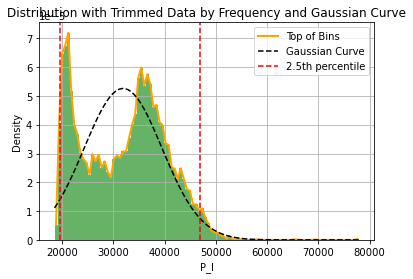

In [25]:
from datetime import datetime
import time


str_date = '2022-09-07'
gaps_percent = 10

date_timestamp = pd.Timestamp(f'{str_date} 00:00:00+0000', tz='UTC')
df_with_season = df_with_season.dropna()
df_all_values = df_with_season.copy()

df_orig, df_test_with_gaps, drop_indexes = create_error_rate_data(df_all_values, date_timestamp, gaps_percent)

In [26]:
# Marking for 10 intervals from Pmin to Pmax
# Pmin and Pmax are taken from the test interval starting from str_date and long in gaps_percent %

df_only_gaps = df_orig.loc[drop_indexes]
load_intervals = create_intervals(df_only_gaps)
# Нумеровка интервалов исходя из того что интервалы были обозначены
#в расках тестовой вырезки
#df_only_gaps['P_l_interval'] = df_only_gaps['P_l'].apply(lambda x: find_interval(x, load_intervals))


In [27]:
# Filling gaps using KNN
filled_df = fill_with_knn(df_test_with_gaps, k=3)


Preparing missing data:   0%|          | 0/621706 [00:00<?, ?it/s]

Preparing missing data: 100%|██████████| 621706/621706 [00:15<00:00, 39076.67it/s]
Applying KNN imputation: 10631it [00:00, 24169.21it/s]


In [6]:
df_test_with_gaps

,P_l,P_l_interval,is_droped
time,,,
2016-06-10 16:50:00+00:00,26441.630,3.0,False
2016-06-10 16:55:00+00:00,26039.196,3.0,False
2016-06-10 17:00:00+00:00,21790.632,1.0,False
2016-06-10 17:05:00+00:00,22824.290,2.0,False
2016-06-10 17:10:00+00:00,23408.187,2.0,False
...,...,...,...
2023-09-11 14:40:00+00:00,30907.000,4.0,False
2023-09-11 14:45:00+00:00,31661.200,5.0,False
2023-09-11 14:50:00+00:00,31766.700,5.0,False


In [6]:
filled_df[filled_df["is_droped"]==True]

,P_l,P_l_interval,is_droped
time,,,
2022-11-16 00:05:00+00:00,21957.200000,2.0,True
2022-11-16 00:10:00+00:00,22455.100000,1.0,True
2022-11-16 00:15:00+00:00,21805.600000,1.0,True
2022-11-16 00:20:00+00:00,22041.000000,1.0,True
2022-11-16 00:25:00+00:00,21148.400000,1.0,True
...,...,...,...
2023-08-01 17:30:00+00:00,24014.716854,4.0,True
2023-08-01 17:35:00+00:00,24014.716854,4.0,True
2023-08-01 17:40:00+00:00,24014.716854,3.0,True


In [7]:
# MAPE
df_predicted_with_error, general_mape, mape_by_interval = calculate_mape_improved(
    df_orig,
    filled_df
)

[(0.0, 15.709928145755), (1.0, 15.841793478531523), (2.0, 23.752670683676367), (3.0, 30.700682998284037), (4.0, 32.7495265835898), (5.0, 27.629194793299924), (6.0, 23.33428074986983), (7.0, 21.15718670101732), (8.0, 20.952399101239816), (9.0, 22.61297899679401)]
[(15124.731, 18453.9037), (18453.9037, 21783.076399999998), (21783.076399999998, 25112.2491), (25112.2491, 28441.4218), (28441.4218, 31770.5945), (31770.5945, 35099.7672), (35099.7672, 38428.9399), (38428.9399, 41758.1126), (41758.1126, 45087.2853), (45087.2853, 48416.458)]


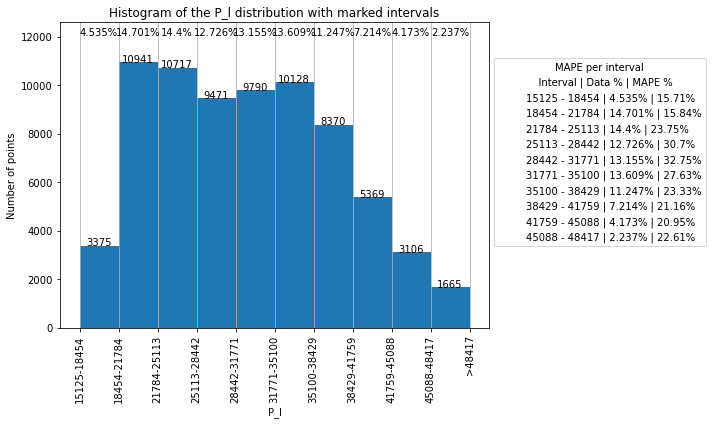

In [8]:
# Histogram of data distribution in df_only_gaps by intervals
import matplotlib.pyplot as plt
import numpy as np
import math as m

def create_intervals_droped(load_intervals):
    intervals = []
    for i in range(len(load_intervals) - 1):
        low_interval = load_intervals[i]
        high_interval = load_intervals[i + 1]
        intervals.append((low_interval, high_interval))
    return intervals

intervals = create_intervals_droped(load_intervals)
print(mape_by_interval)
new_mape_by_interval = []
print(intervals)
for i in range(len(intervals)):
    new_mape_by_interval.append((intervals[i], mape_by_interval[i][1]))

mape_by_interval = new_mape_by_interval

data = df_only_gaps['P_l']

plt.figure(figsize=(10, 6))

n, bins, patches = plt.hist(data, bins=[interval[0] for interval in intervals] + [intervals[-1][1]])

plt.xlabel('P_l')
plt.ylabel('Number of points')
plt.title('Histogram of the P_l distribution with marked intervals')

plt.xticks([interval[0] for interval in intervals] + [intervals[-1][1]],
           [f'{m.ceil(interval[0])}-{m.ceil(interval[1])}' for interval in intervals] + [f'>{m.ceil(intervals[-1][1])}'],
           rotation=90)

plt.grid(axis='x')

total_samples = len(data)
for i, interval in enumerate(intervals):
    count_in_interval = ((data >= interval[0]) & (data <= interval[1])).sum()
    percentage = count_in_interval / total_samples
    width = bins[i + 1] - bins[i]
    plt.text(bins[i] + width / 2, np.max(n) * 1.1, f'{round(percentage * 100, 3)}%', ha='center')  # Уменьшение координаты y для текста процентов
    plt.text(bins[i] + (bins[i + 1] - bins[i]) / 2, count_in_interval, f'{count_in_interval}', ha='center')

plt.plot([], [], label='    Interval | Data % | MAPE %', color='white')

for interval, value in mape_by_interval:
    count_in_interval = ((data >= interval[0]) & (data <= interval[1])).sum()
    percentage = count_in_interval / total_samples
    label = f'{m.ceil(interval[0])} - {m.ceil(interval[1])} | {round(percentage*100, 3)}% | {round(value, 2)}%'
    plt.plot([], [], label=label, color='white')

plt.legend(title='MAPE per interval', facecolor='white', bbox_to_anchor=(1, 0.9))

plt.ylim(0, np.max(n) * 1.15)

plt.tight_layout()

plt.savefig('histogram.png')

plt.show()

In [12]:
df_only_filled = filled_df.loc[drop_indexes]
df_orig_cut = df_orig.loc[drop_indexes]

for interval in range(0, 10):
    orig_values = df_orig_cut[df_orig_cut['P_l_interval'] == interval]['P_l']
    filled_values = df_only_filled[df_only_filled['P_l_interval'] == interval]['P_l']
    rmse = np.sqrt(mean_squared_error(orig_values, filled_values))
    mae = mean_absolute_error(orig_values, filled_values)
    mape_by_interval[interval] = list(mape_by_interval[interval])
    mape_by_interval[interval].append(rmse)
    mape_by_interval[interval].append(mae)

start_interval = []
end_interval = []
mape = []
rmse = []
mae = []

for i in range(len(mape_by_interval)):
    start_interval.append(mape_by_interval[i][0][0])
    end_interval.append(mape_by_interval[i][0][1])
    mape.append(mape_by_interval[i][1])
    rmse.append(mape_by_interval[i][2])
    mae.append(mape_by_interval[i][4])

df_error = pd.DataFrame(columns=['Start Interval', 'End Interval', 'MAPE', 'RMSE', 'MAE'])

df_error['Start Interval'], df_error['End Interval'], df_error['MAPE'], df_error['RMSE'], df_error['MAE'] = start_interval, end_interval, mape, rmse, mae

df_error.to_csv(f'error_{gaps_percent}_gaps.csv')

df_error

,Start Interval,End Interval,MAPE,RMSE,MAE
0,15124.7310,18453.9037,15.709928,3637.253076,3637.253076
1,18453.9037,21783.0764,15.841793,4429.251622,4429.251622
2,21783.0764,25112.2491,23.752671,6806.850810,6806.850810
3,25112.2491,28441.4218,30.700683,9448.717148,9448.717148
4,28441.4218,31770.5945,32.749527,10986.053667,10986.053667
5,31770.5945,35099.7672,27.629195,10688.522256,10688.522256
6,35099.7672,38428.9399,23.334281,10324.933864,10324.933864
7,38428.9399,41758.1126,21.157187,10299.505127,10299.505127
8,41758.1126,45087.2853,20.952399,10931.140830,10931.140830
9,45087.2853,48416.4580,22.612979,12258.235671,12258.235671


In [11]:
# Сохранение df_filled в файл CSV
filled_df.to_csv('/Users/dmitrii/Desktop/PhD/Python/PhD_code_project/Machine-Learning-Techniques-for-Ensuring-the-Health-of-Citizens/notebooks/results/KNN/70%/filled_with_KNN_70proc.csv', index=True)
